In [2]:
import matplotlib.pyplot as plt

In [3]:
import numpy as np
from jax import numpy as jnp
from LI_JAX import RegularGridInterpolator

class limepy_interpolate:
    def __init__(self,**kwargs):
        self._set_constants()
        self._read_int_array()
        
    def _set_constants(self):
        self.G_s = 1
        
        #reference rh and M used for interpolations
        self.rhref, self.Mref = 1.0, 1e5
        self.Wmin, self.Wmax = 1.4, 16
        self.gmin, self.gmax = 0.001, 3.49
        #Number of points for W and g interpolation arrays
        self.N = 200
        #np stands for numpy array (in contrast to JAX array)
        self.g_a_np = np.linspace(self.gmin,self.gmax,self.N)
        self.W_a_np = np.linspace(self.Wmin,self.Wmax,self.N)
        #JAX numpy array
        self.g_a = jnp.linspace(self.gmin,self.gmax,self.N)
        self.W_a = jnp.linspace(self.Wmin,self.Wmax,self.N)
        
        #Maximum cutoff radius that outputs zero
        self.rt_max = 69
        
        N1 = 250
        N2 = 1000
        self.Nr = N1+N2-1
        r_1 = np.linspace(0,self.rhref,N1)
        r_2 = np.linspace(self.rhref,self.rt_max,N2)
        self.r_a = np.r_[r_1[:-1],r_2]
    
    #Boundary functions for g_Phi0 space
    def _set_up_boundary_func(self,offset):
        z = np.polyfit(self.W_a_np, self.g_boundary,10)
        p_f = np.poly1d(z)
        self.boundary_func = p_f-offset
    
    #Cuts the 2D array with W0 as x and g as y
    def bound_cut(self,x,y,array,f_b):
        M,N = np.shape(x)[0],np.shape(y)[0]
        array_cut = np.zeros((M,N))
        for i in range(M):
            j = 0
            while y[j]<f_b(x[i]):
                array_cut[i,j] = array[i,j]
                j += 1
                if j>=N:
                    break
        return array_cut
    
    
    def _read_int_array(self):
        #read numerical values needed for interpolation!
        container = np.load('interp_basic.npz')
        data = [container[key] for key in container]
        rt_2d_np, A_2d_np, s2_2d_np =  data[0], data[1], data[2]
        self.g_boundary = data[3]
    
        self._set_up_boundary_func(offset=0.2)
        
        rt_2d_cut = self.bound_cut(self.W_a_np, self.g_a_np, np.transpose(rt_2d_np), self.boundary_func)
        s2_2d_cut = self.bound_cut(self.W_a_np, self.g_a_np, np.transpose(s2_2d_np), self.boundary_func)
        A_2d_cut = self.bound_cut(self.W_a_np,  self.g_a_np, np.transpose(A_2d_np),  self.boundary_func)

        self.rt_2d = jnp.asarray(rt_2d_cut)
        self.A_2d = jnp.asarray(A_2d_cut)
        self.s2_2d = jnp.asarray(s2_2d_cut)
    
    def _interpolate_coefficients(self):
        self.A_p = RegularGridInterpolator((self.W_a, self.g_a), self.A_2d)
        self.rt_p = RegularGridInterpolator((self.W_a, self.g_a), self.rt_2d)
        self.s2_p = RegularGridInterpolator((self.W_a, self.g_a), self.s2_2d)
    
    def _interpolate_phi(self):
        container = np.load('phi_3d.npz')
        phi_3d = jnp.array([container[key] for key in container])
        self.phi_p = RegularGridInterpolator((self.W_a, self.g_a, self.r_a), phi_3d)
        
    #sum of all points in the distribution function
    def my_df(self,r,v,ii):
        rt_s = self.rt_p(jnp.transpose(ii[:2]))
        s2_s = self.s2_p(jnp.transpose(ii[:2]))
        A_s = self.A_p(jnp.transpose(ii[:2]))
        
        R_s = ii[3]/self.rhref
        M_s = 10**ii[2]/self.Mref

        r_s = r/R_s
        v2_s = self.G_s*M_s/R_s
        s2 = s2_s*v2_s 
        A = A_s*M_s/(v2_s**1.5*R_s**3)
        
        def float_inf(ii,a,b):
            return -jnp.inf
        
        def sum_log_like(ii,E,A):
            return jnp.sum(jnp.log(jnp.exp(E)*jax.scipy.special.gammainc(ii[1],E)*A/(10**ii[2])))
        
        def df_all_r(ii,r_s,v):
            phi_s = self.phi_p(jnp.stack([jnp.ones_like(r_s)*ii[0],\
                                        jnp.ones_like(r_s)*ii[1],r_s],axis=-1))
            phi = phi_s*v2_s
            vesc2 = 2.0*phi
            v2 = v**2
            E = (phi-0.5*v2)/s2
            return jax.lax.cond(jnp.all(v2<vesc2),sum_log_like,float_inf,ii,E,A)

        return jax.lax.cond(jnp.all(r_s<rt_s),df_all_r,float_inf,ii,r_s,v) 


#This class is created with every given data!
#For every different data, we need a class to compute df
class log_df:
     def __init__(self,**kwargs):
        self._set_constants()
        self._read_int_array()


    def my_log_df_center(vec_x=vecx,vec_v=vecv):
   
    def log_myf_cartesian_center(ii):   
        r = jnp.sqrt((self.vec_x[0]-ii[4])**2+(self.vec_x[1]-ii[5])**2+(vec_x[2]-ii[6])**2)
        v = jnp.sqrt((self.vec_v[0]-ii[7])**2+(vec_v[1]-ii[8])**2+(vec_v[2]-ii[9])**2) 
        fr = my_df(r,v,ii)
        return fr
    return log_myf_center
my_df_jit = jax.jit(my_log_df())
from jax import grad
my_df_grad_jit = jax.jit(grad(my_log_df()))

In [4]:
#Only Need to initialize once to create a method for limepy interpolated df
a = limepy_interpolate()
a._interpolate_coefficients()
a._interpolate_phi()

In [5]:
import jax
my_df_func_jax = jax.jit(a.my_df_func)
my_df_jax = jax.jit(a.my_df)

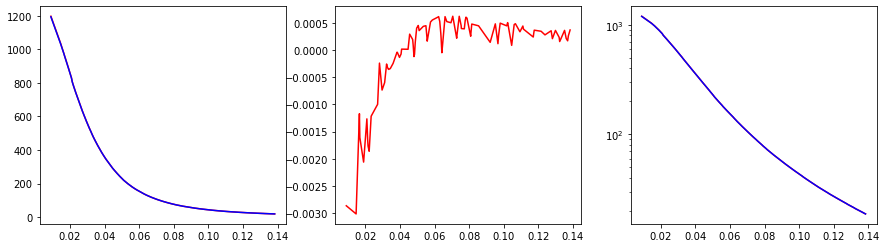

In [5]:
from limepy import limepy,sample

W0test, gtest, rhtest, Mtest = 10, 0.1, 1 ,3.1617e4
k = limepy(W0test, gtest, M=Mtest, rh=rhtest)
ic = sample(k, N=1000)

W0_t = np.array([W0test])
g_t = np.array([gtest])
log10M_t = np.log10(np.array([Mtest]))
rh_t = np.array([rhtest])
xhhh = np.array([W0_t,g_t,log10M_t,rh_t])

rtest = np.sort(ic.r)[:100]
vtest = np.sort(ic.v)[:100]

df_true = k.df(rtest,vtest)
df_test = my_df_func_jax(rtest,vtest,xhhh)

fig, ax_lst = plt.subplots(1,3,figsize=(15,4))

ax = ax_lst[0]
ax.plot(rtest,df_true,c='red')
ax.plot(rtest,df_test,c='blue')

ax = ax_lst[1]
ax.plot(rtest,(df_test-df_true)/(df_true+0.00001),c='red')

ax = ax_lst[2]
ax.plot(rtest,df_true,c='red')
ax.plot(rtest,df_test,c='blue')
ax.set_yscale('log')

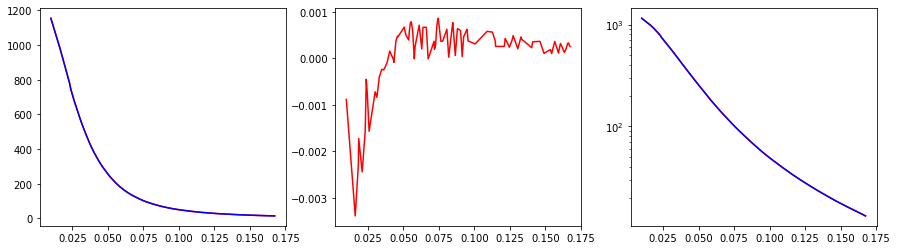

In [6]:
from limepy import limepy,sample

W0test, gtest, rhtest, Mtest = 10.21, 0.134, 1.2 ,3.1617e4
k = limepy(W0test, gtest, M=Mtest, rh=rhtest)
ic = sample(k, N=1000)

W0_t = np.array([W0test])
g_t = np.array([gtest])
log10M_t = np.log10(np.array([Mtest]))
rh_t = np.array([rhtest])
xhhh = np.array([W0_t,g_t,log10M_t,rh_t])

rtest = np.sort(ic.r)[:100]
vtest = np.sort(ic.v)[:100]

df_true = k.df(rtest,vtest)
df_test = my_df_func_jax(rtest,vtest,xhhh)

fig, ax_lst = plt.subplots(1,3,figsize=(15,4))

ax = ax_lst[0]
ax.plot(rtest,df_true,c='red')
ax.plot(rtest,df_test,c='blue')

ax = ax_lst[1]
ax.plot(rtest,(df_test-df_true)/(df_true+0.00001),c='red')

ax = ax_lst[2]
ax.plot(rtest,df_true,c='red')
ax.plot(rtest,df_test,c='blue')
ax.set_yscale('log')

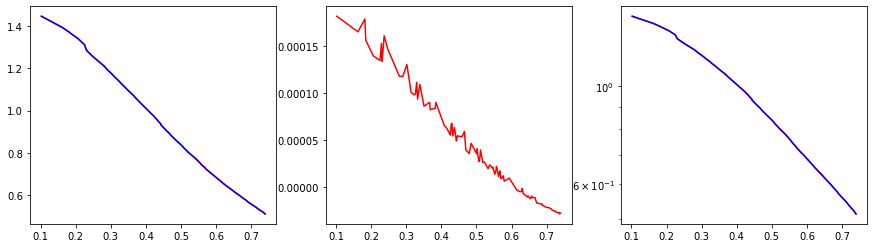

In [7]:
from limepy import limepy,sample

W0test, gtest, rhtest, Mtest = 6.21362, 1.5341, 2.2747 ,3.1617e5
k = limepy(W0test, gtest, M=Mtest, rh=rhtest)
ic = sample(k, N=1000)

W0_t = np.array([W0test])
g_t = np.array([gtest])
log10M_t = np.log10(np.array([Mtest]))
rh_t = np.array([rhtest])
xhhh = np.array([W0_t,g_t,log10M_t,rh_t])

rtest = np.sort(ic.r)[:100]
vtest = np.sort(ic.v)[:100]

df_true = k.df(rtest,vtest)
df_test = my_df_func_jax(rtest,vtest,xhhh)

fig, ax_lst = plt.subplots(1,3,figsize=(15,4))

ax = ax_lst[0]
ax.plot(rtest,df_true,c='red')
ax.plot(rtest,df_test,c='blue')

ax = ax_lst[1]
ax.plot(rtest,(df_test-df_true)/(df_true+0.00001),c='red')

ax = ax_lst[2]
ax.plot(rtest,df_true,c='red')
ax.plot(rtest,df_test,c='blue')
ax.set_yscale('log')

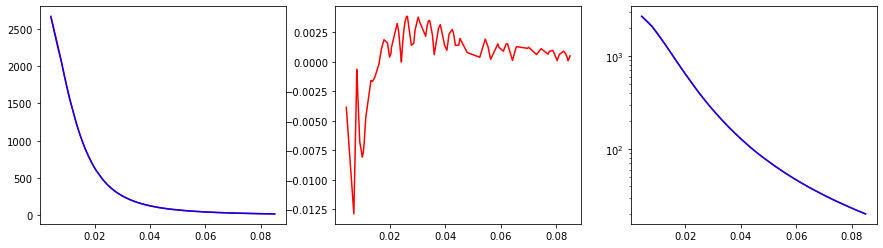

In [40]:
from limepy import limepy,sample

W0test, gtest, rhtest, Mtest = 10, 2, 1 ,1e5
k = limepy(W0test, gtest, M=Mtest, rh=rhtest)
ic = sample(k, N=1000)

W0_t = np.array([W0test])
g_t = np.array([gtest])
log10M_t = np.log10(np.array([Mtest]))
rh_t = np.array([rhtest])
xhhh = np.array([W0_t,g_t,log10M_t,rh_t])

rtest = np.sort(ic.r)[:100]
vtest = np.sort(ic.v)[:100]

df_true = k.df(rtest,vtest)
df_test = my_df_func_jax(rtest,vtest,xhhh)

fig, ax_lst = plt.subplots(1,3,figsize=(15,4))

ax = ax_lst[0]
ax.plot(rtest,df_true,c='red')
ax.plot(rtest,df_test,c='blue')

ax = ax_lst[1]
ax.plot(rtest,(df_test-df_true)/(df_true+0.00001),c='red')

ax = ax_lst[2]
ax.plot(rtest,df_true,c='red')
ax.plot(rtest,df_test,c='blue')
ax.set_yscale('log')

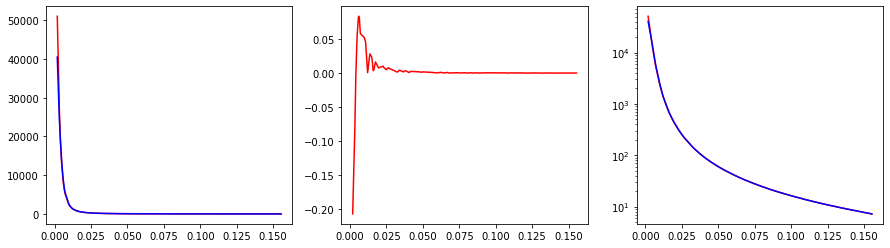

In [41]:
from limepy import limepy,sample

W0test, gtest, rhtest, Mtest = 14, 2, 1 ,1e5
k = limepy(W0test, gtest, M=Mtest, rh=rhtest)
ic = sample(k, N=1000)

W0_t = np.array([W0test])
g_t = np.array([gtest])
log10M_t = np.log10(np.array([Mtest]))
rh_t = np.array([rhtest])
xhhh = np.array([W0_t,g_t,log10M_t,rh_t])

rtest = np.sort(ic.r)[:100]
vtest = np.sort(ic.v)[:100]

df_true = k.df(rtest,vtest)
df_test = my_df_func_jax(rtest,vtest,xhhh)

fig, ax_lst = plt.subplots(1,3,figsize=(15,4))

ax = ax_lst[0]
ax.plot(rtest,df_true,c='red')
ax.plot(rtest,df_test,c='blue')

ax = ax_lst[1]
ax.plot(rtest,(df_test-df_true)/(df_true+0.00001),c='red')

ax = ax_lst[2]
ax.plot(rtest,df_true,c='red')
ax.plot(rtest,df_test,c='blue')
ax.set_yscale('log')

In [34]:
def test_dist(W0test, gtest, rhtest, Mtest):
    k = limepy(W0test, gtest, M=Mtest, rh=rhtest)
    ic = sample(k, N=1000)

    W0_t = np.array([W0test])
    g_t = np.array([gtest])
    log10M_t = np.log10(np.array([Mtest]))
    rh_t = np.array([rhtest])
    xhhh = np.array([W0_t,g_t,log10M_t,rh_t])

    #index = np.argsort(ic.r)[:250]
    
    #rtest = ic.r[index]
    #vtest = np.min(ic.v)
    rtest = k.r[:100]
    vtest = np.zeros(len(rtest))

    df_true = k.df(rtest,vtest)
    df_test = my_df_func_jax(rtest,vtest,xhhh)

    fig, ax_lst = plt.subplots(1,4,figsize=(18,4))

    ax = ax_lst[0]
    ax.plot(rtest,df_true,c='red')
    ax.plot(rtest,df_test,c='blue')
    

    ax = ax_lst[1]
    ax.plot(rtest,(df_test-df_true)/(df_true+0.000001),c='red')
    ax.set_title('difference of df')

    ax = ax_lst[2]
    ax.plot(rtest,df_true,c='red')
    ax.plot(rtest,df_test,c='blue')
    ax.set_yscale('log')
    
    
    ax = ax_lst[3]
    nlast = len(rtest)//5*4
    ax.plot(rtest[:nlast],(np.log(df_test[:nlast])-np.log(df_true[:nlast]))/(np.log(df_true[:nlast])),c='red')
    #ax.set_yscale('log')
    ax.set_title('difference of log df')

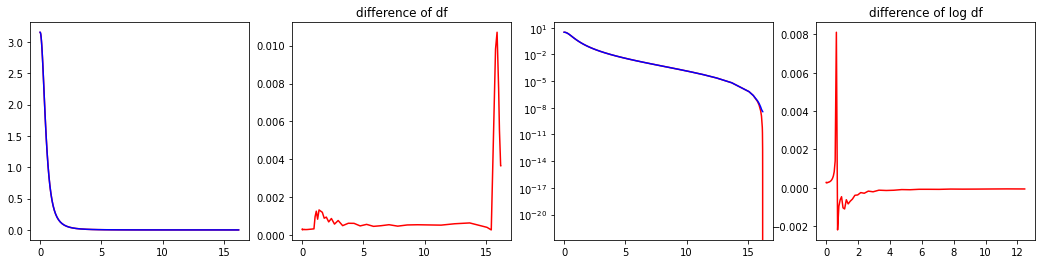

In [35]:
W0test, gtest, rhtest, Mtest = 3.5, 2.5, 1 ,1e5
test_dist(W0test, gtest, rhtest, Mtest)

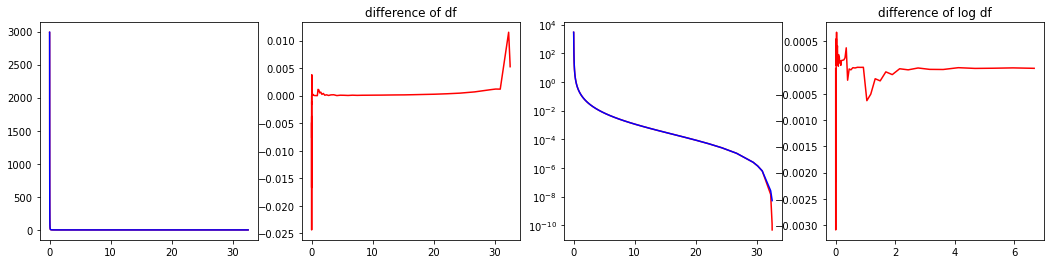

In [36]:
W0test, gtest, rhtest, Mtest = 10, 2, 1 ,1e5
test_dist(W0test, gtest, rhtest, Mtest)

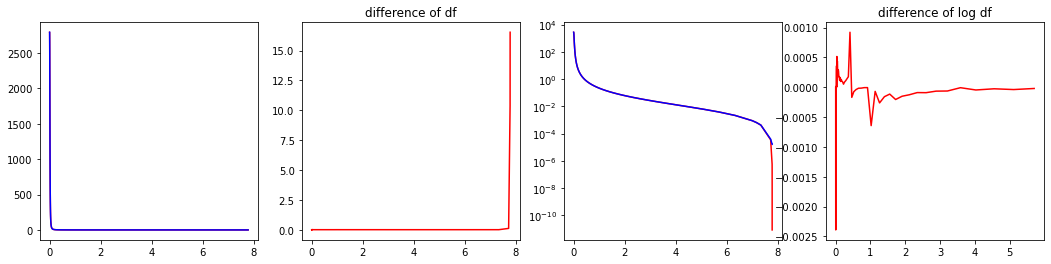

In [38]:
W0test, gtest, rhtest, Mtest = 11, 1.2, 1 ,1e5
test_dist(W0test, gtest, rhtest, Mtest)

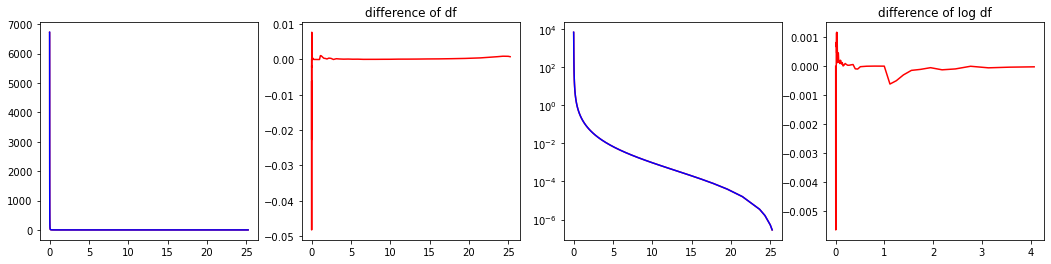

In [39]:
W0test, gtest, rhtest, Mtest = 11, 2, 1 ,1e5
test_dist(W0test, gtest, rhtest, Mtest)

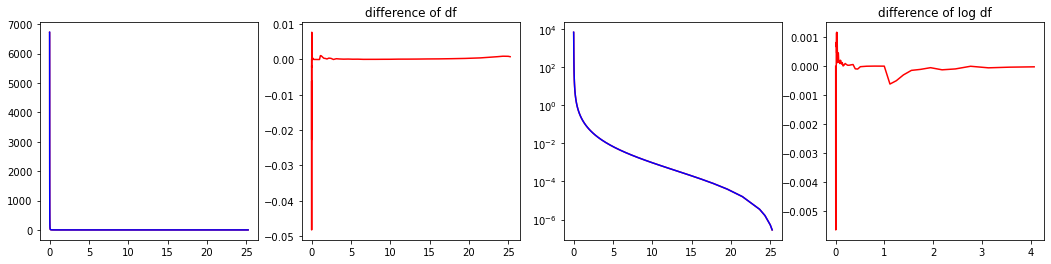

In [39]:
W0test, gtest, rhtest, Mtest = 11, 2, 1 ,1e5
test_dist(W0test, gtest, rhtest, Mtest)

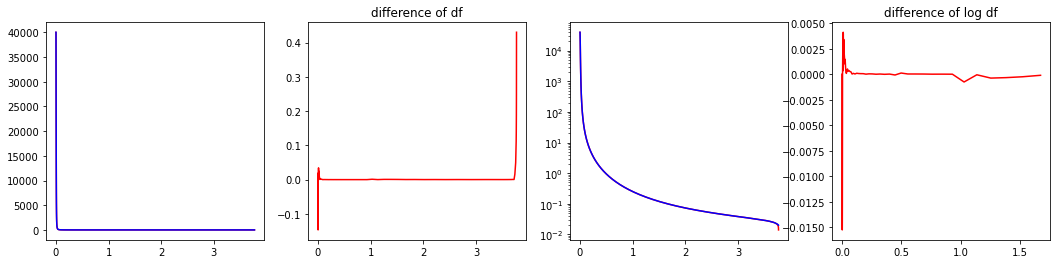

In [42]:
W0test, gtest, rhtest, Mtest = 14, 0.1, 1 ,1e5
test_dist(W0test, gtest, rhtest, Mtest)

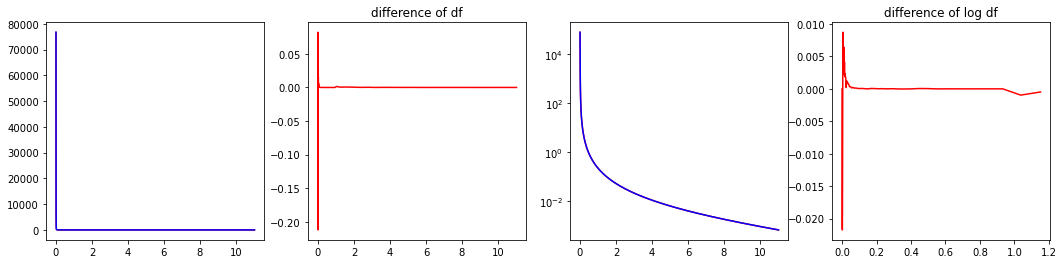

In [43]:
W0test, gtest, rhtest, Mtest = 14, 2, 1 ,1e5
test_dist(W0test, gtest, rhtest, Mtest)

In [12]:
#Code to fill PhiArrays

N1 = 250
N2 = 1000
Nt = N1+N2-1
r_1 = np.linspace(0,a.rhref,N1)
r_2 = np.linspace(a.rhref,a.rt_max,N2)
np.r_[r_1[:-1],r_2]
phi_3d = np.zeros((a.N,a.N,Nt))

#we need a better interpolation function to allow varying grids
#Should seek a way to modify interpolation function in JAX!
#More flexible 3D interpolation function should be useful!

import scipy
from limepy import limepy
for i in range(len(a.W_a_np)):
    if i%10==0:
        print(i)
    for j in range(len(a.g_a_np)):
        u = limepy(a.W_a_np[i], a.g_a_np[j], M=a.Mref,rh=a.rhref)
        _phi_poly = scipy.interpolate.BPoly.from_derivatives(u.r,\
                np.transpose(np.array([u.phi,u.dphidr1])))
        if a.rt_2d_np[j,i] != u.rt:
            print(i,j,'wrong rt')
        inrt = (r_a<u.rt)
        result = np.zeros(Nt)
    
        if (sum(inrt)>0): result[inrt] = _phi_poly(r_a[inrt])
        phi_3d[i,j,:] = result
        
np.savez('phi_3d.npz',*phi_3d)